# <center>Estimating mean profiles and fluxes in high-speed turbulent boundary layers using inner/outer-layer transformations</center>

             Created on: Jul, 2023
                Authors: Rene Pecnik (R.Pecnik@tudelft.nl)
                         Asif M. Hasan (a.m.hasan@tudelft.nl)
                         Process & Energy Department, Faculty of 3mE
                         Delft University of Technology, the Netherlands.

       Last modified on: Jul, 2023
                     by: Rene Pecnik 


The following equations are solved iteratively in this notebook. Refer to the paper for more details: https://doi.org/10.48550/arXiv.2307.02199.



# Required functions 
Required inputs are $Re_\theta$, $M_\infty$, $T_w/T_r$ and (optionally) the dimensional wall or free-stream temperature for Sutherland's law.  It is important to note that all solver inputs are based on the quantities in the free-stream, and not at the boundary layer edge.

### 1. Mean velocity (in non-dimensional form)
The mean velocity is obtained by 

$$ \bar u^+ = 
\int_{y/y_e=0}^1 
\left[\vphantom{\frac{1}{2}}\right.
\underbrace{\frac{\mu_w}{\bar \mu} \frac{1}{1 + \mu_t}}_{\text{inner layer}}
+  
\underbrace{\frac{\sqrt{\rho_w/\bar\rho}}{Re_\tau} \, \frac{\Pi}{\kappa} \, \pi\, \sin \left(\pi \frac{y}{\delta}\right)}_{\text{outer layer}}
\left.\vphantom{\frac{1}{2}}\right]
dy^+, $$

with the Johnson-King eddy eddy viscosity model, defined as 

$$\mu_t = \kappa y^* D(M_\tau), $$

and the modified van Driest damping function

$$ D(M_{\tau}) = \left[1 - \mathrm{exp}\left({\frac{-y^*}{A^+ + f(M_\tau)}}\right)\right]^2. $$

The constants and the function to account for intrinsic compressiblity effects in $D$ are given as

$$A^+ = 17,~\kappa=0.41,~f(M_\tau)=19.3M_\tau. $$

The wake parameter is obtained by 

$${\Pi} = 0.69\,\left[1 - \exp(-0.243 \sqrt{z} - {0.15} \,z)\right],$$
with
$$z = Re_\theta/425 - 1.$$

In [14]:
def meanVelocity(ReTheta, ReTau, MTau, y_ye, r_rw, mu_muw):
    
    # Semi local Reynolds number and scaled wall distances 
    ReTauSt = ReTau*np.sqrt(r_rw)/mu_muw
    ypl     = y_ye*ReTau
    yst     = y_ye*ReTauSt
    
    # eddy viscosity model
    D   = (1-np.exp(-yst/(Apl + 19.3*MTau)))**2
    mut = kappa*yst*D
    
    # wake parameter
    z1   = ReTheta/425-1
    Pi   = 0.69*(1 - np.exp(-0.243*z1**0.5 - 0.150*z1))
    Wake = Pi/kappa*np.pi*np.sin(np.pi*y_ye)
    
    # velocity 
    upl  = cumtrapz( 1/mu_muw/(1 + mut) + 1/ReTau/np.sqrt(r_rw)*Wake, ypl, initial=0)
    
    uinf = upl[-1]/0.99 # calculate uinf
        
    return ypl, yst, upl, uinf

### 2. Temperature velocity relationship (Zhang et al. (2014), JFM)

$$\frac{\bar T}{T_w} =1+\frac{T_r-T_w}{T_w} \left[(1-s\,{Pr})\left(\frac{\bar u^+}{u^+_\infty}\right)^2+s \, {Pr}\left(\frac{\bar u^+}{u_\infty^+}\right)\right]+\frac{T_\infty-T_r}{T_w}\left(\frac{\bar u^+}{u^+_\infty}\right)^2,$$

where 

$$s{Pr}=0.8,~T_r/T_\infty = 1 + 0.5 r (\gamma-1)M_\infty^2,~r=Pr^{1/3},~\text{and}~Pr=0.72.$$


In [15]:
def temperature(u_uinf, Minf, Tw_Tr):
    
    r = Pr**(1/3)
    Tr_Tinf = 1 + r*(gamma - 1)/2*Minf**2
    Tinf_Tw = 1/(Tw_Tr*Tr_Tinf)        
    al   = 0.8
    f_u  = (1 - al)*(u_uinf)**2 + al*(u_uinf)
    T_Tw = 1 + (1/Tw_Tr - 1)*f_u + (Tinf_Tw - 1/Tw_Tr)*(u_uinf)**2
    
    return T_Tw, Tinf_Tw

### 3. Density profile (using ideal gas equation of state)
$$\frac{\bar\rho}{\rho_w} = \frac{T_w}{\bar T}$$

In [16]:
def density(T_Tw):
    return 1/T_Tw

### 4. Viscosity profile (using Sutherland's law)
$$\frac{\bar\mu}{\mu_w}=\left(\frac{\bar T}{T_w}\right)^{3 / 2} \frac{T_w+S}{\bar T+S},$$

where S = 110.56 K

In [17]:
def viscosity(T_Tw, Tinf_dim, Tinf_Tw, viscLaw):

    if viscLaw == "Sutherland":
        S     = 110.56/Tinf_dim * Tinf_Tw
        mu_muw= T_Tw**(1.5)*(1 + S)/(T_Tw + S)

    elif viscLaw == "PowerLaw":
        mu_muw = T_Tw**0.75

    else:
        print('Viscosity law ', viscLaw, " not available")
    
    return mu_muw

### 5. Computing $Re_\tau$ and $M_\tau$ using the inputs $Re_\theta$ and $M_\infty$
$$Re_\tau = {Re_\theta}\frac{ \mu_\infty/\mu_w}{(\rho_\infty/\rho_w) u_\infty^+ (\theta/\delta)}$$

$$M_\tau = M_\infty \sqrt{\frac{c_f}{2}}$$

In [18]:
def calcParameters(ReTheta, Minf, y_ye, r_rw, mu_muw, upl, uinf, T_Tw, Tw_Tr, Tinf_Tw, Tinf_dim, viscLaw):
    
    rinf    =   density(Tinf_Tw)
    muinf   =   viscosity(Tinf_Tw, Tinf_dim, Tinf_Tw, viscLaw)    
    
    Theta         = trapz(r_rw/rinf*upl/uinf*(1 - upl/uinf), y_ye)
    ReTheta_ReTau = rinf*uinf*Theta/muinf
    ReTau         = ReTheta/ReTheta_ReTau
    cf            = 2/(rinf*uinf**2)
    MTau          = Minf*(cf/2)**0.5    

    ch = np.inf
    if Tw_Tr != 1:
        ch        = 1/ReTau/Pr*dTdyWall(T_Tw,y_ye)/(rinf*uinf*(1/Tw_Tr - 1))   
    
    return ReTau, MTau, cf, ch

# Iterative solver

In [19]:
import numpy as np
from scipy.integrate import cumtrapz, trapz

In [20]:
def grid(H,n,fact):
    tanhyp = 0.5
    i = tanhyp*(np.arange(0,n))/(n-1) - 0.5
    y = 1./tanhyp*H * (1.0 + np.tanh(fact*i)/np.tanh(fact/2))/2.0
    return y

In [21]:
def dTdyWall(T,y):
    derivUniform = (-3*T[0]+4*T[1]-1*T[2])/2.0
    derivGrid    = -1/60*-y[3] + 0.15*-y[2] - 0.75*-y[1] \
                 +1/60* y[3] - 0.15* y[2] + 0.75* y[1]
    return derivUniform/derivGrid 

In [22]:
def Solver(ReTheta = 1000, Minf = 1.0, Tw_Tr = 1.0,    
                  viscLaw = "Sutherland", Tinf_dim = 300):
    
    # Generate grid
    y_ye = grid(1, 360, 5)  # (domain size, number of cells, stretching factor)
    
    # set initial values for ReTau, MTau and upl
    ReTau = 100
    MTau  = 0.0
    upl   = np.ones_like(y_ye)*0.1
    uinf  = upl[-1]/0.99

    niter = 0
    err   = 1e10
    
    while(err > 1e-10 and niter < 1000):

        ReTauOld = ReTau
        
        T_Tw, Tinf_Tw       = temperature(upl/uinf, Minf, Tw_Tr)
        mu_muw              = viscosity(T_Tw, Tinf_dim,Tinf_Tw, viscLaw)
        r_rw                = density (T_Tw) 
        ypl, yst, upl, uinf = meanVelocity(ReTheta, ReTau, MTau, y_ye, r_rw, mu_muw)        
        ReTau, MTau, cf, ch = calcParameters(ReTheta, Minf, y_ye, r_rw, mu_muw, upl, uinf, T_Tw, Tw_Tr, Tinf_Tw,
                                              Tinf_dim, viscLaw)

        err = abs(ReTauOld-ReTau)
        niter += 1

    return cf, ch, ReTau, MTau, ypl, yst, upl, T_Tw, niter

# A single case with $M_\infty=5.86$, $Re_\theta=40775$, and $T_w/T_r= 0.76$

In [23]:
########################################
# Constants
#
gamma     = 1.4    # ratio of specific heat capacities
Pr        = 0.72   # Prandtl number
kappa     = 0.41   # Karman constant 
Apl       = 17     # Van Driest damping constant 


########################################
# Inputs for a test case
#
Minf      = 5.86
ReTheta   = 40774.6527128768
Tw_Tr     = 0.76
viscLaw   = "Sutherland"
Tinf_dim  = 169.4


cf,ch,ReTau,MTau,ypl,yst,upl,T, niter = Solver(ReTheta=ReTheta, Minf=Minf, Tw_Tr=Tw_Tr,
                                               viscLaw=viscLaw, Tinf_dim=Tinf_dim)

print('Convergence reached after {0} iterations.'.format(niter))
print('\nSkin friction coefficient cf = {0:.5e} \nHeat Transfer coefficient ch = {1:.5e}'.format(cf, ch))

Convergence reached after 23 iterations.

Skin friction coefficient cf = 6.80183e-04 
Heat Transfer coefficient ch = 3.77010e-04


### Plot mean profiles

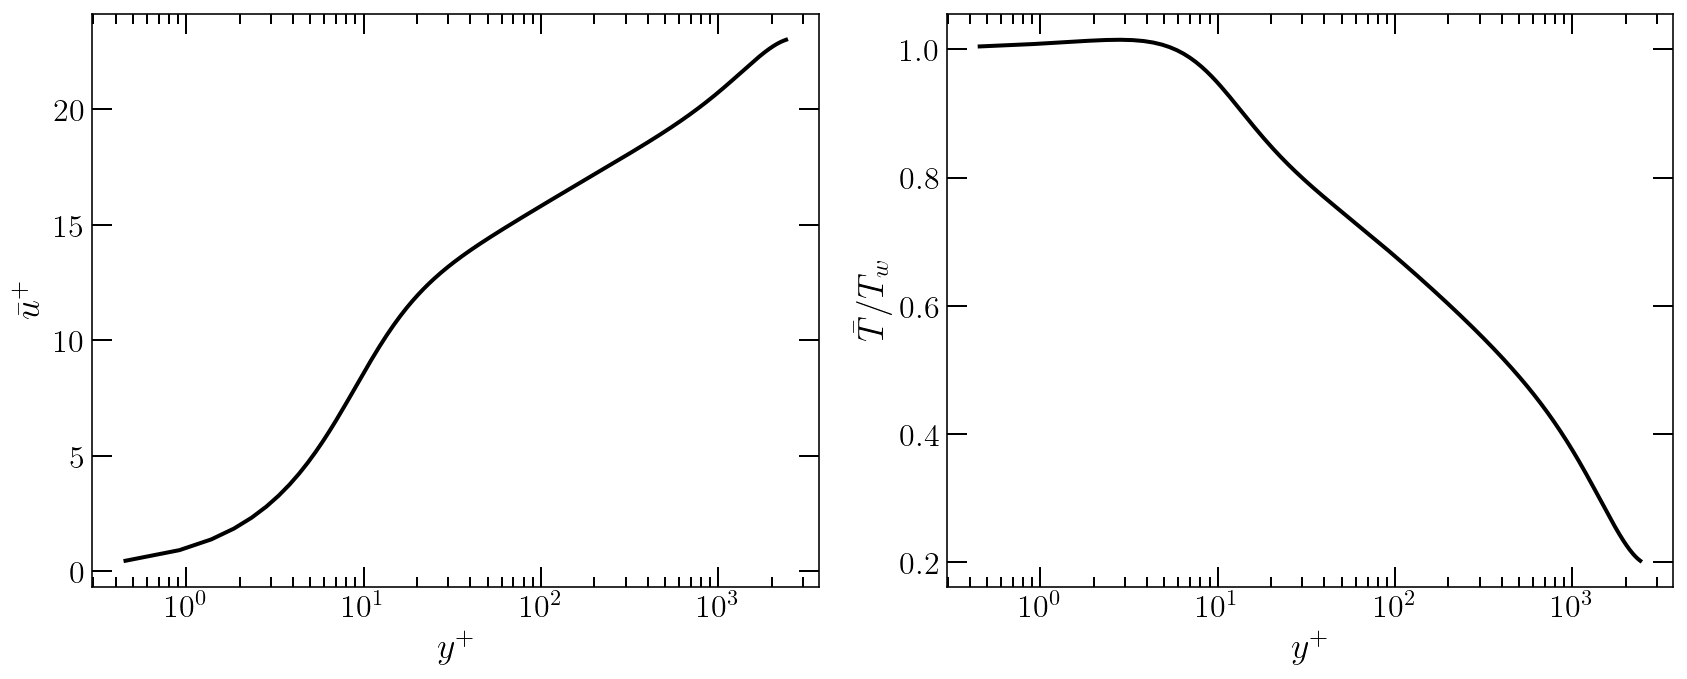

In [24]:
import matplotlib.pyplot as plt
from matplotlib import rc, rcParams
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
rc('text', usetex=True)  # switch to False incase the notebook is slow!!!!
rcParams.update({'font.size': 16})

fig, ax = plt.subplots(1,2,figsize=(12,5))    

ax[0].semilogx(ypl[1:],upl[1:],'k-', lw=2)
ax[1].semilogx(ypl[1:],T[1:],  'k-', lw=2)

ax[0].set_ylabel(r"$\bar u^+$",  fontsize = 18)
ax[1].set_ylabel(r"$\bar T/T_w$",fontsize = 18)
ax[0].set_xlabel(r"$y^+$",fontsize = 18)
ax[1].set_xlabel(r"$y^+$",fontsize = 18)

for a in ax:
    a.tick_params(axis='both', which='both', direction='in',labelsize=16,right=True,top=True)
    a.tick_params(which='major', length=10, width=1)
    a.tick_params(which='minor', length=5, width=1)

plt.tight_layout()

# Comparing cf and ch with various DNS cases in literature

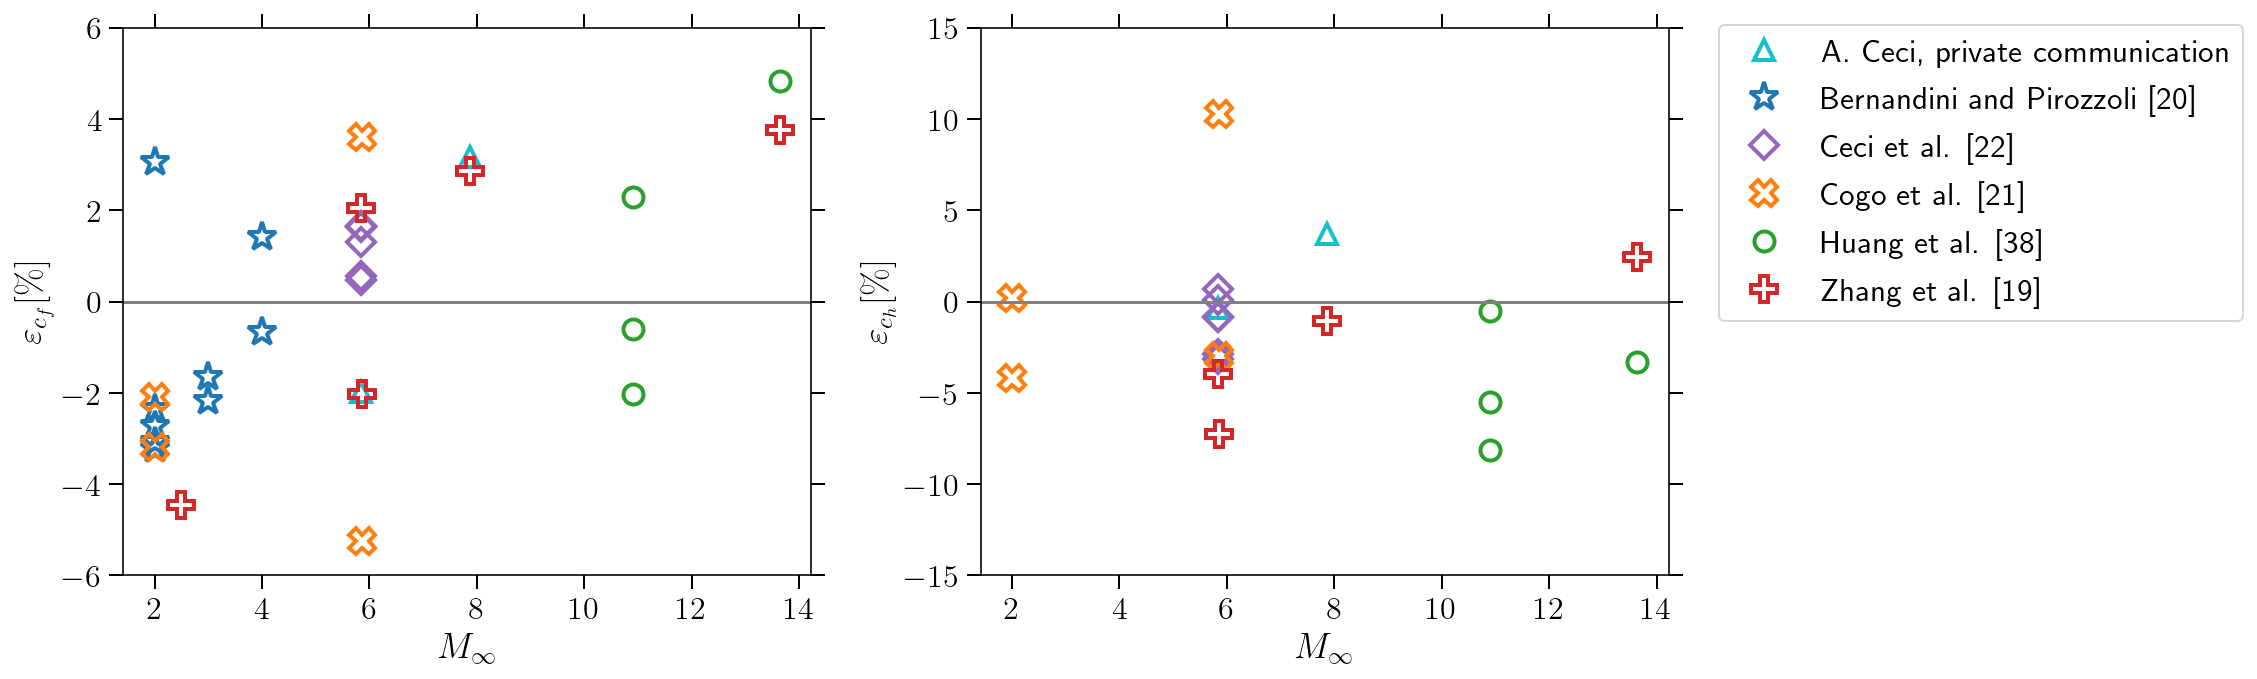

In [25]:
import pandas as pd
DNS = pd.read_csv("DataForDragAndHeatTransfer.csv")
groups = DNS.groupby('Author', as_index=True)


fig, ax = plt.subplots(1,2,figsize=(16,5))

for group_name, group in groups:
    for row_index, row in group.reset_index().iterrows():
        
        Minf      = row['Minf']
        ReTheta   = row['ReTheta']
        Tw_Tr     = row['Tw_Tr']
        viscLaw   = row['ViscLaw']
        Tinf_dim  = row['Tinf']
        cf_DNS    = row['cf_DNS']
        ch_DNS    = row['ch_DNS']

        label = None
        if row_index == 0:
            label = row['Author']

        cf,ch,_,_,_,_,_,_,_ = Solver(ReTheta=ReTheta, Minf=Minf, Tw_Tr=Tw_Tr,
                                     viscLaw=viscLaw, Tinf_dim=Tinf_dim)

        cf_err = (cf-cf_DNS)/cf_DNS*100
        ch_err = (ch-ch_DNS)/ch_DNS*100

        ax[0].plot(Minf, cf_err, marker = row['Symbol'], color = row['Color'], ms=10*row['Size'], 
             mew=2, fillstyle='none', linestyle='None', label=label)
        ax[1].plot(Minf, ch_err, marker = row['Symbol'], color = row['Color'], ms=10*row['Size'], 
             mew=2, fillstyle='none', linestyle='None', label=label)


ax[0].set_xlabel(r"$M_\infty$",fontsize = 18)
ax[1].set_xlabel(r"$M_\infty$",fontsize = 18)
ax[0].set_ylabel(r"$\varepsilon_{c_f}[\%]$",fontsize = 18)
ax[1].set_ylabel(r"$\varepsilon_{c_h}[\%]$",fontsize = 18)

ax[0].set_ylim([-6, 6])
ax[1].set_ylim([-15, 15])

for a in ax:
    a.tick_params(axis='both', which='both', direction='out',labelsize=16,right=True,top=True)
    a.tick_params(which='major', length=7, width=1)
    a.tick_params(which='minor', length=4, width=1)

ax[0].axhline(y=0, color="gray", linestyle="-")
ax[1].axhline(y=0, color="gray", linestyle="-")

ax[1].legend(bbox_to_anchor=(1.05, 1.035))

plt.tight_layout()

## Plot estimated velocity and temperature profiles for these cases

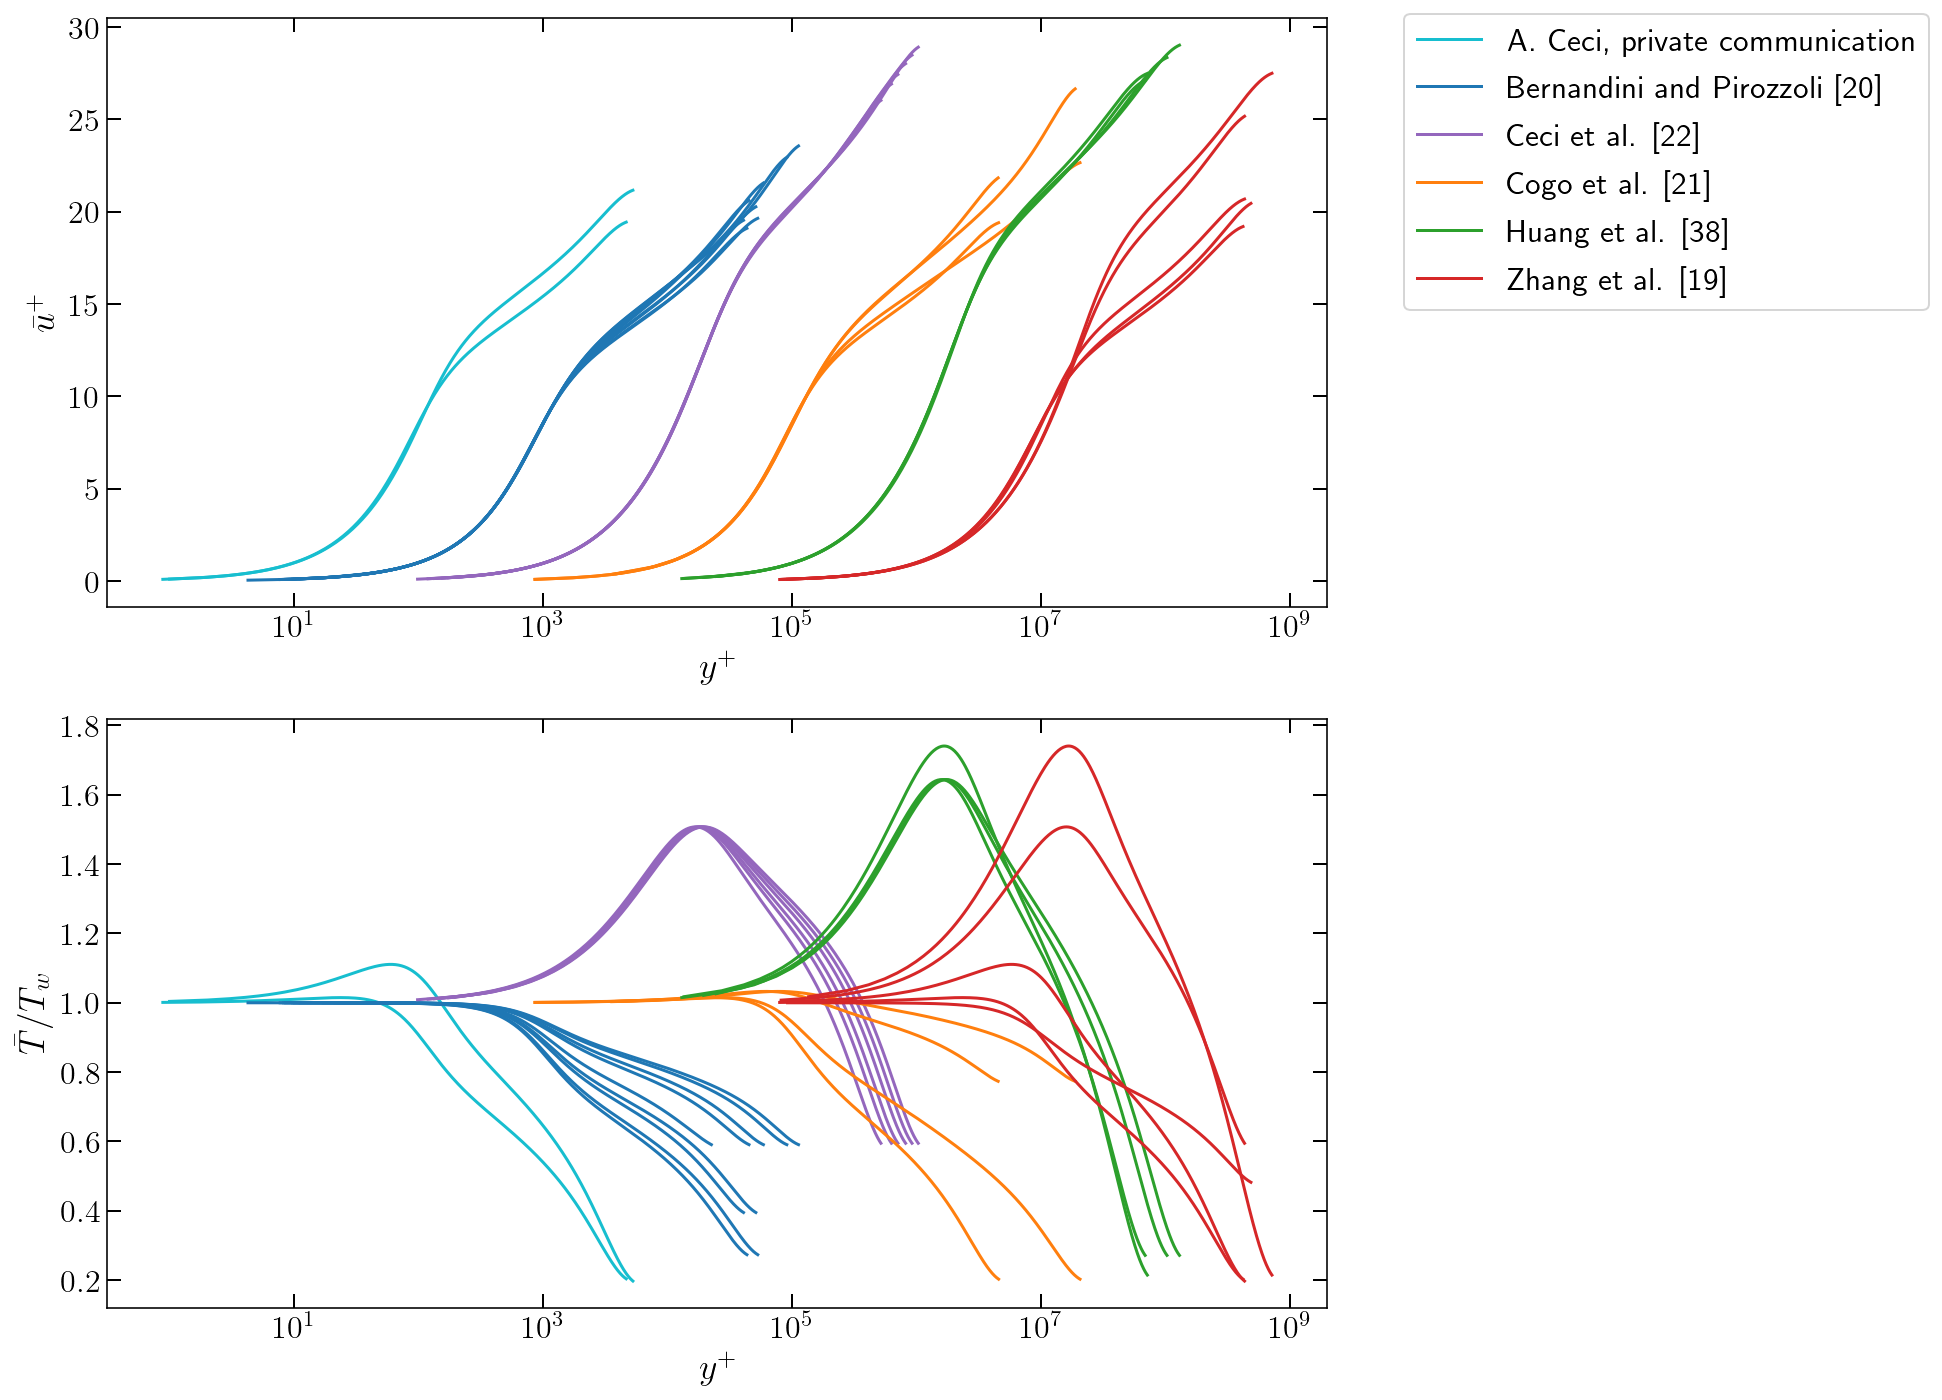

In [26]:
fig, ax = plt.subplots(2,1,figsize=(14,10))

add_x = 1
for group_name, group in groups:
    for row_index, row in group.reset_index().iterrows():
        
        Minf      = row['Minf']
        ReTheta   = row['ReTheta']
        Tw_Tr     = row['Tw_Tr']
        viscLaw   = row['ViscLaw']
        Tinf_dim  = row['Tinf']
        cf_DNS    = row['cf_DNS']
        ch_DNS    = row['ch_DNS']

        label = None
        if row_index == 0:
            label = row['Author']
            add_x *= 10

        _,_,_,_,ypl, yst, upl, T_Tw,_ = Solver(ReTheta=ReTheta, Minf=Minf, Tw_Tr=Tw_Tr,
                                               viscLaw=viscLaw, Tinf_dim=Tinf_dim)

        ax[0].semilogx(ypl[1:]*add_x, upl[1:],  color = row['Color'], label=label)
        ax[1].semilogx(ypl[1:]*add_x, T_Tw[1:], color = row['Color'], label=label)


ax[0].set_ylabel(r"$\bar u^+$",  fontsize = 18)
ax[1].set_ylabel(r"$\bar T/T_w$",fontsize = 18)
ax[0].set_xlabel(r"$y^+$",fontsize = 18)
ax[1].set_xlabel(r"$y^+$",fontsize = 18)

for a in ax:
    a.tick_params(axis='both', which='both', direction='in',labelsize=16,right=True,top=True)
    a.tick_params(which='major', length=7, width=1)
    a.tick_params(which='minor', length=4, width=1)

ax[0].legend(bbox_to_anchor=(1.05, 1.035))

plt.tight_layout()